In [28]:
import os
import numpy as np# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import wandb
from mmengine import Config
from diffusers.utils.torch_utils import randn_tensor
# Add this import for the scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from EEG import UNet1DModelWrapper, DDIMScheduler, DDIMPipeline1D, EEGDataset1D
from tqdm.notebook import tqdm
import wandb
from mmengine import Config
from diffusers.utils.torch_utils import randn_tensor
from EEG import UNet1DModelWrapper, DDIMScheduler, DDIMPipeline1D, EEGDataset1D

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directories if they don't exist
os.makedirs("outputs/1d_model", exist_ok=True)
os.makedirs("caches/prediction", exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
# Load UNet model from config
config = Config.fromfile('config/EEG-Diff/_base_/unet_1d.py')
# Remove 'type' from the config dictionary
unet_config = config.unet.copy()
if 'type' in unet_config:
    del unet_config['type']  # Remove 'type' key which causes the error
unet = UNet1DModelWrapper(**unet_config)

In [ ]:
# Find latest model checkpoint
try:
    model_dirs = [d for d in os.listdir("outputs/1d_model") if d.isdigit()]
    if model_dirs:
        latest_dir = max(model_dirs, key=int)
        model_path = f"outputs/1d_model/{latest_dir}/unet.pth"
        print(f"Loading model weights from {model_path}")
        unet.load_state_dict(torch.load(model_path, map_location=device))
    else:
        print("No trained model found. Using random weights.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Using random weights.")

unet.to(device)
unet.eval()

In [16]:
# Create noise scheduler and pipeline
scheduler_config = Config.fromfile('config/EEG-Diff/_base_/noise_scheduler.py')
scheduler_params = scheduler_config.noise_scheduler.copy()
if 'type' in scheduler_params:
    del scheduler_params['type']  # Remove 'type' key
scheduler = DDIMScheduler(**scheduler_params)
pipeline = DDIMPipeline1D(unet=unet, scheduler=scheduler)
pipeline.to(device)

# Get prediction point from config
eval_config = Config.fromfile('config/EEG-Diff/evaluator_1d.py')
prediction_point = eval_config.evaler.evaler_config.prediction_point
print(f"Using prediction point: {prediction_point}")

Using prediction point: 934


In [22]:
# Load configurations
config = Config.fromfile('config/EEG-Diff/_base_/unet_1d.py')
scheduler_config = Config.fromfile('config/EEG-Diff/_base_/noise_scheduler.py')
train_config = Config.fromfile('config/EEG-Diff/trainer_1d.py')

# Extract configuration parameters
unet_config = config.unet.copy()
if 'type' in unet_config:
    del unet_config['type']

scheduler_params = scheduler_config.noise_scheduler.copy()
if 'type' in scheduler_params:
    del scheduler_params['type']

In [26]:
# Use parameters from train_config
prediction_point = train_config.trainner.trainner_config.prediction_point
num_train_timesteps = train_config.trainner.trainner_config.num_train_timesteps
train_batch_size = train_config.trainner.trainner_config.train_batch_size
learning_rate = train_config.trainner.optimizer.learning_rate
num_epochs = train_config.trainner.trainner_config.num_epochs
lr_warmup_steps = train_config.trainner.trainner_config.lr_warmup_steps

# Print training parameters
print(f"Training parameters:")
print(f"  Prediction point: {prediction_point}")
print(f"  Number of timesteps: {num_train_timesteps}")
print(f"  Batch size: {train_batch_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Number of epochs: {num_epochs}")
print(f"  LR warmup steps: {lr_warmup_steps}")

# Define normalization function
def normalize_1d(tensor):
    """Normalize tensor to [-1, 1] range"""
    return (tensor - 0.5) / 0.5

# Custom normalization function (alternative approach - uncomment to use)
def z_score_normalize(tensor):
    """Apply z-score normalization"""
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    return (tensor - mean) / (std + 1e-6)  # Add small epsilon to avoid division by zero

# Custom loss function with more weight on predicted part
def weighted_mse_loss(noise_pred, noise_target, prediction_point):
    """
    Custom loss function that weights the predicted part more heavily
    """
    # Calculate MSE normally
    mse = F.mse_loss(noise_pred, noise_target, reduction='none')
    
    # Create weight tensor (1.0 for conditional part, 3.0 for prediction part)
    weights = torch.ones_like(noise_pred)
    weights[:, :, prediction_point:] = 3.0  # Weight prediction part 3x more
    
    # Apply weights and take mean
    weighted_mse = (mse * weights).mean()
    
    return weighted_mse

# Simple data augmentation function
def augment_eeg(signal, strength=0.05):
    """Apply simple augmentation to EEG signals"""
    # Add small amplitude noise
    noise = torch.randn_like(signal) * strength
    augmented = signal + noise
    
    return augmented

# Create and initialize the model
def create_model():
    """Create and initialize the UNet model"""
    unet = UNet1DModelWrapper(**unet_config)
    unet.to(device)
    return unet

# Create noise scheduler
def create_scheduler():
    """Create the noise scheduler"""
    return DDIMScheduler(**scheduler_params)

# Training function
def train_model(num_epochs=num_epochs, use_augmentation=True, use_weighted_loss=True, save_intervals=5):
    """Train the diffusion model"""
    # Create model and scheduler
    unet = create_model()
    scheduler = create_scheduler()
    
    # Create datasets
    train_dataset = EEGDataset1D(csv_path='data/train.csv', sequence_length=1280)
    val_dataset = EEGDataset1D(csv_path='data/test.csv', sequence_length=1280)
    
    train_dataset.transform = normalize_1d
    val_dataset.transform = normalize_1d
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=train_batch_size, 
        shuffle=True
    )
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=train_batch_size, 
        shuffle=False
    )
    
    # Create optimizer and scheduler
    optimizer = torch.optim.AdamW(
        unet.parameters(), 
        lr=learning_rate,
        weight_decay=1e-5  # Add weight decay to reduce overfitting
    )
    
    # lr_scheduler = get_cosine_schedule_with_warmup(
    #     optimizer=optimizer,
    #     num_warmup_steps=lr_warmup_steps,
    #     num_training_steps=(len(train_dataloader) * num_epochs),
    # )

    from torch.optim.lr_scheduler import CosineAnnealingLR
    lr_scheduler = CosineAnnealingLR(
            optimizer, 
            T_max=(len(train_dataloader) * num_epochs) - lr_warmup_steps, 
            eta_min=0
        )
    
    # Initialize wandb if you want to use it
    # wandb.init(project="eeg-diffusion", name="training-run")
    
    # Training loop
    num_update_steps_per_epoch = len(train_dataloader)
    total_steps = num_epochs * num_update_steps_per_epoch
    
    # Training metrics tracking
    train_losses = []
    val_losses = []
    
    # Progress bars
    progress_bar = tqdm(range(total_steps), desc="Training")
    
    unet.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        
        for step, batch in enumerate(train_dataloader):
            clean_signals = batch[0].to(device)
            
            # Apply augmentation if enabled
            if use_augmentation:
                clean_signals = augment_eeg(clean_signals)
            
            # Sample random noise
            noise = torch.randn(clean_signals.shape).to(device)
            
            # Sample a random timestep for each example
            timesteps = torch.randint(
                0,
                num_train_timesteps,
                (clean_signals.shape[0],),
                device=device
            ).long()
            
            # Add noise to clean signals
            noisy_signals = scheduler.add_noise(clean_signals, noise, timesteps)
            
            # Keep conditional part unchanged (important for prediction!)
            noisy_signals[:, :, :prediction_point] = clean_signals[:, :, :prediction_point]
            
            # Predict noise
            noise_pred = unet(noisy_signals, timesteps).sample
            
            # Calculate loss
            if use_weighted_loss:
                loss = weighted_mse_loss(noise_pred, noise, prediction_point)
            else:
                # Standard MSE loss but only on the predicted part
                loss = F.mse_loss(
                    noise_pred[:, :, prediction_point:],
                    noise[:, :, prediction_point:]
                )
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            # Track metrics
            epoch_losses.append(loss.item())
            
            # Update progress bar
            progress_bar.update(1)
            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
        
        # End of epoch processing
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_loss)
        
        # Validation
        unet.eval()
        val_epoch_losses = []
        
        with torch.no_grad():
            for val_batch in val_dataloader:
                val_clean_signals = val_batch[0].to(device)
                
                # Sample random noise
                val_noise = torch.randn(val_clean_signals.shape).to(device)
                
                # Sample a random timestep for each example
                val_timesteps = torch.randint(
                    0,
                    num_train_timesteps,
                    (val_clean_signals.shape[0],),
                    device=device
                ).long()
                
                # Add noise to clean signals
                val_noisy_signals = scheduler.add_noise(val_clean_signals, val_noise, val_timesteps)
                
                # Keep conditional part unchanged
                val_noisy_signals[:, :, :prediction_point] = val_clean_signals[:, :, :prediction_point]
                
                # Predict noise
                val_noise_pred = unet(val_noisy_signals, val_timesteps).sample
                
                # Calculate loss
                if use_weighted_loss:
                    val_loss = weighted_mse_loss(val_noise_pred, val_noise, prediction_point)
                else:
                    val_loss = F.mse_loss(
                        val_noise_pred[:, :, prediction_point:],
                        val_noise[:, :, prediction_point:]
                    )
                
                val_epoch_losses.append(val_loss.item())
        
        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        
        # Log metrics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # wandb.log({
        #     "epoch": epoch,
        #     "train_loss": avg_loss,
        #     "val_loss": avg_val_loss,
        #     "learning_rate": lr_scheduler.get_last_lr()[0]
        # })
        
        # Save model at intervals
        if (epoch + 1) % save_intervals == 0 or epoch == num_epochs - 1:
            save_dir = f"outputs/1d_model/{epoch+1}"
            os.makedirs(save_dir, exist_ok=True)
            torch.save(unet.state_dict(), f"{save_dir}/unet.pth")
            print(f"Model saved to {save_dir}/unet.pth")
        
        # Switch back to training mode
        unet.train()
    
    # Save final model
    save_dir = "outputs/1d_model/final"
    os.makedirs(save_dir, exist_ok=True)
    torch.save(unet.state_dict(), f"{save_dir}/unet.pth")
    print(f"Final model saved to {save_dir}/unet.pth")
    
    # Create symlink to latest model
    os.makedirs("outputs/1d_model/latest", exist_ok=True)
    torch.save(unet.state_dict(), "outputs/1d_model/latest/unet.pth")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("outputs/1d_model/training_curve.png")
    plt.show()
    
    return unet, scheduler, train_losses, val_losses

Training parameters:
  Prediction point: 934
  Number of timesteps: 3000
  Batch size: 32
  Learning rate: 0.0001
  Number of epochs: 200
  LR warmup steps: 100


Starting model training...


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 3.6797, Val Loss: 1.9668
Epoch 2/200, Train Loss: 1.7173, Val Loss: 1.4596
Epoch 3/200, Train Loss: 1.4789, Val Loss: 1.4821
Epoch 4/200, Train Loss: 1.3845, Val Loss: 1.3032
Epoch 5/200, Train Loss: 1.3140, Val Loss: 1.2769
Epoch 6/200, Train Loss: 1.2839, Val Loss: 1.2828
Epoch 7/200, Train Loss: 1.2508, Val Loss: 1.2805
Epoch 8/200, Train Loss: 1.2433, Val Loss: 1.2873
Epoch 9/200, Train Loss: 1.2305, Val Loss: 1.2016
Epoch 10/200, Train Loss: 1.2146, Val Loss: 1.2226
Epoch 11/200, Train Loss: 1.2196, Val Loss: 1.1816
Epoch 12/200, Train Loss: 1.2088, Val Loss: 1.2621
Epoch 13/200, Train Loss: 1.1967, Val Loss: 1.2090
Epoch 14/200, Train Loss: 1.2046, Val Loss: 1.2333
Epoch 15/200, Train Loss: 1.1947, Val Loss: 1.1759
Epoch 16/200, Train Loss: 1.1971, Val Loss: 1.2097
Epoch 17/200, Train Loss: 1.1885, Val Loss: 1.1985
Epoch 18/200, Train Loss: 1.1906, Val Loss: 1.2041
Epoch 19/200, Train Loss: 1.1816, Val Loss: 1.1927
Epoch 20/200, Train Loss: 1.1758, Val Lo

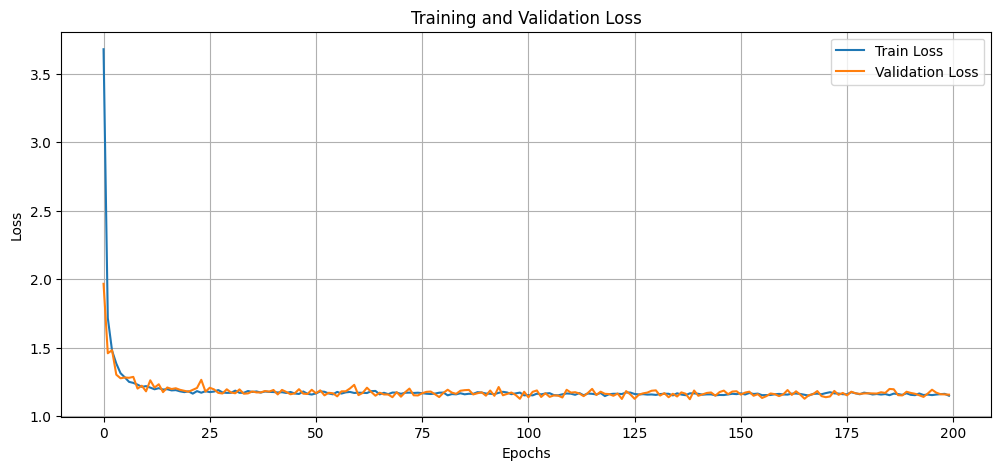

In [30]:
# 1. Train the model
print("Starting model training...")
# Change parameters as needed
model, scheduler, train_losses, val_losses = train_model(
    num_epochs=200,            # Reduced for demonstration
    use_augmentation=True,    # Use data augmentation
    use_weighted_loss=True,   # Use weighted loss
    save_intervals=50          # Save model every 5 epochs
)

In [31]:
# Normalization function
# def normalize_1d(tensor):
#     """Normalize tensor to [-1, 1] range"""
#     return (tensor - 0.5) / 0.5

# Calculate metrics function
def calculate_metrics(original, predicted, prediction_point=None):
    """Calculate error metrics between original and predicted signals"""
    # Calculate overall metrics
    mse = np.mean((predicted - original) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predicted - original))
    
    # Calculate R² (coefficient of determination)
    ss_res = np.sum((original - predicted) ** 2)
    ss_tot = np.sum((original - np.mean(original)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    metrics = {
        "overall": {
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "r_squared": r_squared
        }
    }
    
    # If prediction point is provided, calculate metrics for predicted part only
    if prediction_point is not None:
        pred_mse = np.mean((predicted[:, :, prediction_point:] - original[:, :, prediction_point:]) ** 2)
        pred_rmse = np.sqrt(pred_mse)
        pred_mae = np.mean(np.abs(predicted[:, :, prediction_point:] - original[:, :, prediction_point:]))
        
        pred_ss_res = np.sum((original[:, :, prediction_point:] - predicted[:, :, prediction_point:]) ** 2)
        pred_ss_tot = np.sum((original[:, :, prediction_point:] - np.mean(original[:, :, prediction_point:])) ** 2)
        pred_r_squared = 1 - (pred_ss_res / pred_ss_tot) if pred_ss_tot != 0 else 0
        
        metrics["predicted_part"] = {
            "mse": pred_mse,
            "rmse": pred_rmse,
            "mae": pred_mae,
            "r_squared": pred_r_squared
        }
    
    return metrics

# Visualization function for individual samples
def visualize_samples(dataset_path, num_samples=5, prediction_point=640):
    """Visualize predictions for samples from a dataset"""
    # Create dataset
    dataset = EEGDataset1D(csv_path=dataset_path, sequence_length=1280)
    #dataset.transform = normalize_1d
    
    # Sample indices
    num_samples = min(num_samples, len(dataset))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Initialize arrays to store results
    originals = []
    predictions = []
    
    # Process each sample
    for idx in indices:
        # Get sample
        sample = dataset[idx][0].unsqueeze(0).to(device)  # Add batch dimension
        
        # Generate initial noise
        signal_with_noise = randn_tensor(sample.shape, device=device, dtype=unet.dtype)
        
        # Keep the initial part unchanged
        signal_with_noise[:, :, :prediction_point] = sample[:, :, :prediction_point]
        
        # Generate prediction
        with torch.no_grad():
            predicted_signal = pipeline.do_prediction(
                signal_with_noise,
                prediction_point,
                batch_size=1,
                num_inference_steps=200  # Same as in training
            )
        
        # Denormalize signals
        original_signal_np = dataset.denormalize_with_min_max(sample.cpu().numpy())
        predicted_signal_np = dataset.denormalize_with_min_max(predicted_signal.cpu().numpy())
        
        # Store results
        originals.append(original_signal_np)
        predictions.append(predicted_signal_np)
    
    # Visualize results
    for i in range(num_samples):
        # Get original and predicted signals
        original = originals[i][0, 0, :]  # Remove batch and channel dimensions
        predicted = predictions[i][0, 0, :]
        
        # Plot original vs predicted
        plt.figure(figsize=(15, 6))
        plt.plot(original, label='Original')
        plt.plot(predicted, label='Predicted')
        plt.axvline(x=prediction_point, color='r', linestyle='--', label=f'Prediction Point ({prediction_point})')
        plt.title(f'Sample {i+1} - Original vs Predicted EEG Signal')
        plt.xlabel('Time Point')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot error
        plt.figure(figsize=(15, 4))
        error = np.abs(predicted - original)
        plt.plot(error)
        plt.axvline(x=prediction_point, color='r', linestyle='--', label=f'Prediction Point ({prediction_point})')
        plt.title(f'Sample {i+1} - Absolute Error')
        plt.xlabel('Time Point')
        plt.ylabel('Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Calculate metrics for this sample
        mse = np.mean((predicted - original) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(predicted - original))
        
        # Calculate R² (coefficient of determination)
        ss_res = np.sum((original - predicted) ** 2)
        ss_tot = np.sum((original - np.mean(original)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        
        print(f"Sample {i+1} Metrics - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r_squared:.4f}")
        
        # Calculate metrics for predicted part only
        pred_mse = np.mean((predicted[prediction_point:] - original[prediction_point:]) ** 2)
        pred_rmse = np.sqrt(pred_mse)
        pred_mae = np.mean(np.abs(predicted[prediction_point:] - original[prediction_point:]))
        
        pred_ss_res = np.sum((original[prediction_point:] - predicted[prediction_point:]) ** 2)
        pred_ss_tot = np.sum((original[prediction_point:] - np.mean(original[prediction_point:])) ** 2)
        pred_r_squared = 1 - (pred_ss_res / pred_ss_tot) if pred_ss_tot != 0 else 0
        
        print(f"Predicted Part Metrics - MSE: {pred_mse:.4f}, RMSE: {pred_rmse:.4f}, MAE: {pred_mae:.4f}, R²: {pred_r_squared:.4f}\n")

# Function to evaluate entire dataset
def evaluate_dataset(dataset_path, batch_size=8, prediction_point=640):
    """Evaluate model performance on an entire dataset"""
    # Create dataset
    dataset = EEGDataset1D(csv_path=dataset_path, sequence_length=1280)
    #dataset.transform = normalize_1d
    
    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize arrays to store results
    all_originals = []
    all_predictions = []
    
    # Process each batch
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            samples = batch[0].to(device)
            
            # Generate initial noise
            signals_with_noise = randn_tensor(samples.shape, device=device, dtype=unet.dtype)
            
            # Keep the initial part unchanged
            signals_with_noise[:, :, :prediction_point] = samples[:, :, :prediction_point]
            
            # Generate predictions
            predicted_signals = pipeline.do_prediction(
                signals_with_noise,
                prediction_point,
                batch_size=len(samples),
                num_inference_steps=200  # Same as in training
            )
            
            # Denormalize signals
            original_signals_np = dataset.denormalize_with_min_max(samples.cpu().numpy())
            predicted_signals_np = dataset.denormalize_with_min_max(predicted_signals.cpu().numpy())
            
            # Store results
            all_originals.append(original_signals_np)
            all_predictions.append(predicted_signals_np)
    
    # Concatenate results
    all_originals = np.concatenate(all_originals, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    
    # Calculate metrics
    metrics = calculate_metrics(all_originals, all_predictions, prediction_point)
    
    print(f"\nOverall metrics:")
    print(f"  MSE: {metrics['overall']['mse']:.4f}")
    print(f"  RMSE: {metrics['overall']['rmse']:.4f}")
    print(f"  MAE: {metrics['overall']['mae']:.4f}")
    print(f"  R²: {metrics['overall']['r_squared']:.4f}")
    
    print(f"\nPredicted part metrics:")
    print(f"  MSE: {metrics['predicted_part']['mse']:.4f}")
    print(f"  RMSE: {metrics['predicted_part']['rmse']:.4f}")
    print(f"  MAE: {metrics['predicted_part']['mae']:.4f}")
    print(f"  R²: {metrics['predicted_part']['r_squared']:.4f}")
    
    return all_originals, all_predictions, metrics

# Function to plot average performance
def plot_average_performance(originals, predictions, prediction_point):
    """Plot average performance across all samples"""
    # Calculate mean and std
    mean_original = np.mean(originals[:, 0, :], axis=0)
    std_original = np.std(originals[:, 0, :], axis=0)
    mean_predicted = np.mean(predictions[:, 0, :], axis=0)
    std_predicted = np.std(predictions[:, 0, :], axis=0)
    
    # Plot means with confidence intervals
    plt.figure(figsize=(15, 8))
    x = np.arange(len(mean_original))
    
    # Plot original signal
    plt.plot(mean_original, 'b-', label='Original (Mean)')
    plt.fill_between(
        x, 
        mean_original - std_original, 
        mean_original + std_original, 
        color='b', 
        alpha=0.2, 
        label='Original (±1 Std)'
    )
    
    # Plot predicted signal
    plt.plot(mean_predicted, 'r-', label='Predicted (Mean)')
    plt.fill_between(
        x, 
        mean_predicted - std_predicted, 
        mean_predicted + std_predicted, 
        color='r', 
        alpha=0.2, 
        label='Predicted (±1 Std)'
    )
    
    # Add vertical line at prediction point
    plt.axvline(x=prediction_point, color='g', linestyle='--', label=f'Prediction Point ({prediction_point})')
    
    plt.title('Average Performance Across All Samples')
    plt.xlabel('Time Point')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot mean absolute error
    mean_error = np.mean(np.abs(predictions[:, 0, :] - originals[:, 0, :]), axis=0)
    std_error = np.std(np.abs(predictions[:, 0, :] - originals[:, 0, :]), axis=0)
    
    plt.figure(figsize=(15, 6))
    plt.plot(mean_error, 'k-', label='MAE')
    plt.fill_between(
        x, 
        mean_error - std_error, 
        mean_error + std_error, 
        color='k', 
        alpha=0.2, 
        label='MAE (±1 Std)'
    )
    
    # Add vertical line at prediction point
    plt.axvline(x=prediction_point, color='g', linestyle='--', label=f'Prediction Point ({prediction_point})')
    
    plt.title('Mean Absolute Error Across All Samples')
    plt.xlabel('Time Point')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()


Visualizing training samples:


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

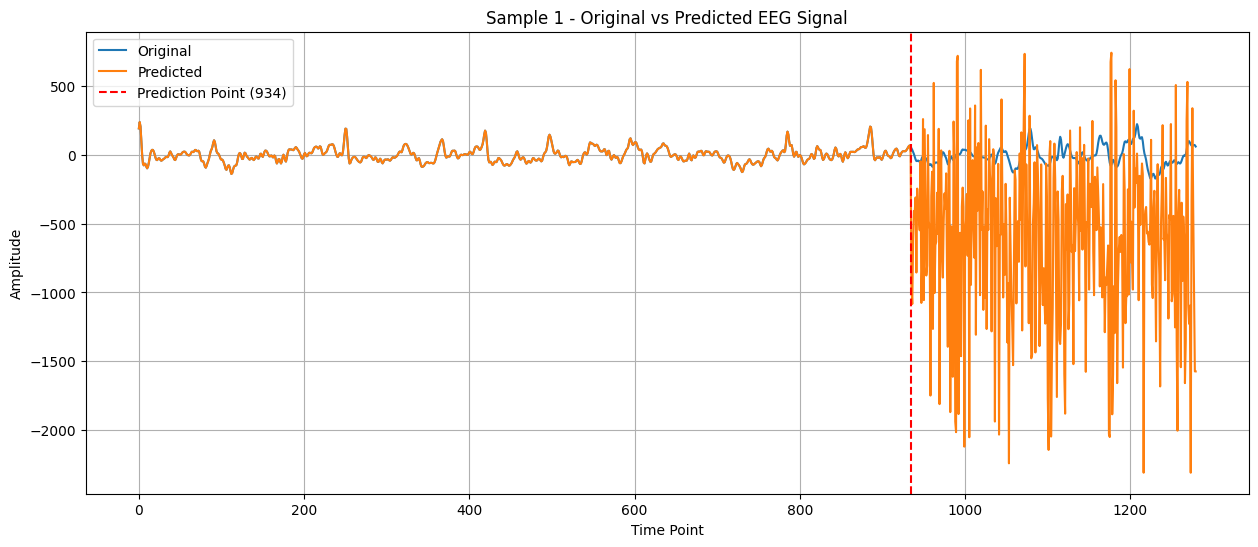

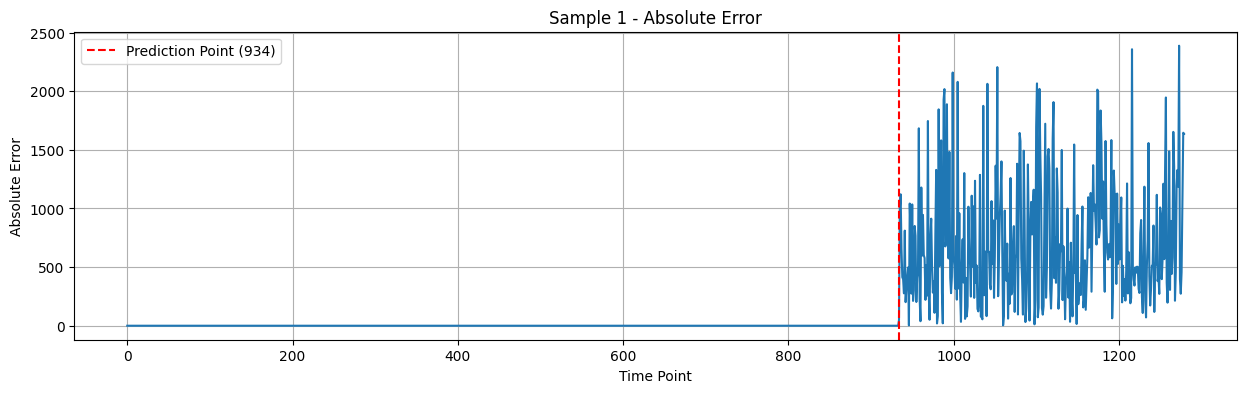

Sample 1 Metrics - MSE: 208631.1250, RMSE: 456.7616, MAE: 189.0525, R²: -63.7853
Predicted Part Metrics - MSE: 771814.6250, RMSE: 878.5298, MAE: 699.3848, R²: -154.5452



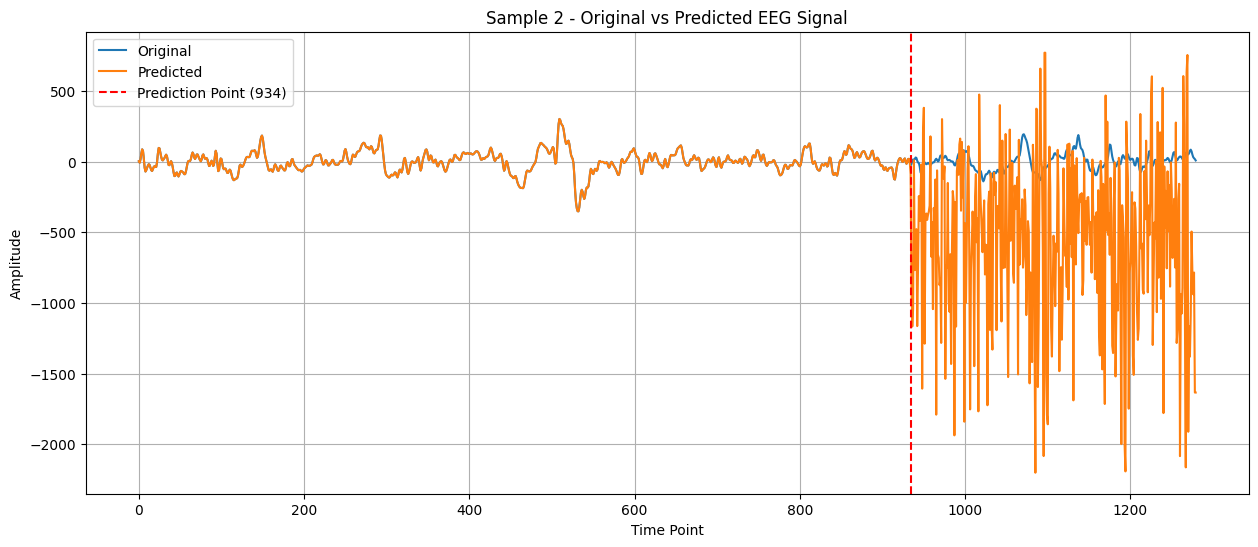

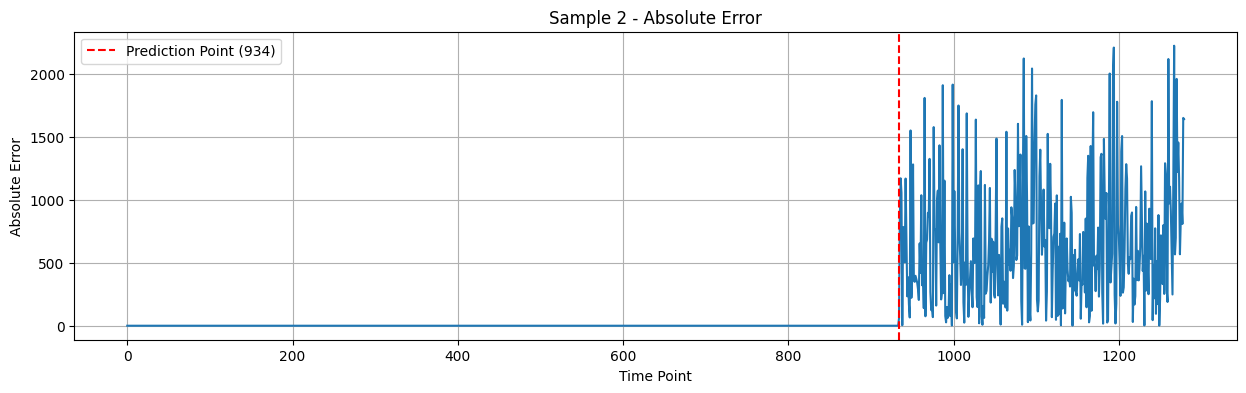

Sample 2 Metrics - MSE: 187076.5625, RMSE: 432.5235, MAE: 177.1760, R²: -37.7283
Predicted Part Metrics - MSE: 692075.1875, RMSE: 831.9106, MAE: 655.4490, R²: -195.5899



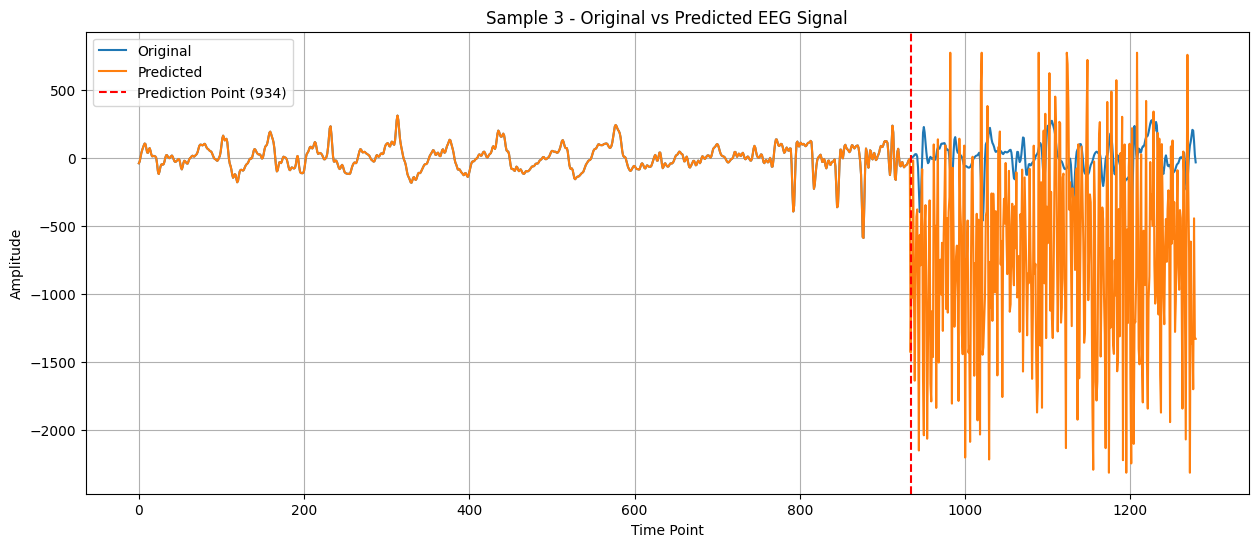

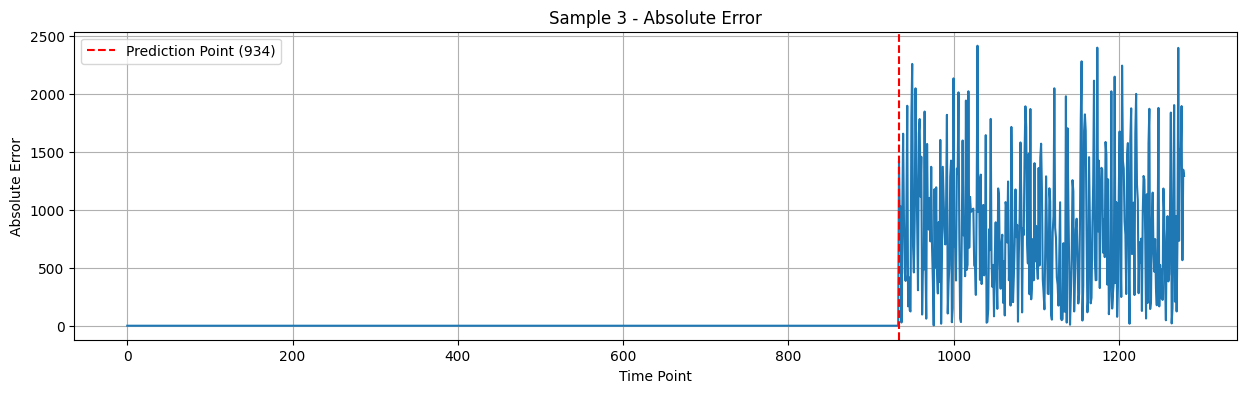

Sample 3 Metrics - MSE: 283222.7188, RMSE: 532.1867, MAE: 226.5557, R²: -26.9868
Predicted Part Metrics - MSE: 1047760.4375, RMSE: 1023.6017, MAE: 838.1252, R²: -63.8349



In [32]:
# Execute the analysis
# Visualize some training samples
print("\nVisualizing training samples:")
visualize_samples('data/train.csv', num_samples=3, prediction_point=prediction_point)


Visualizing test samples:


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

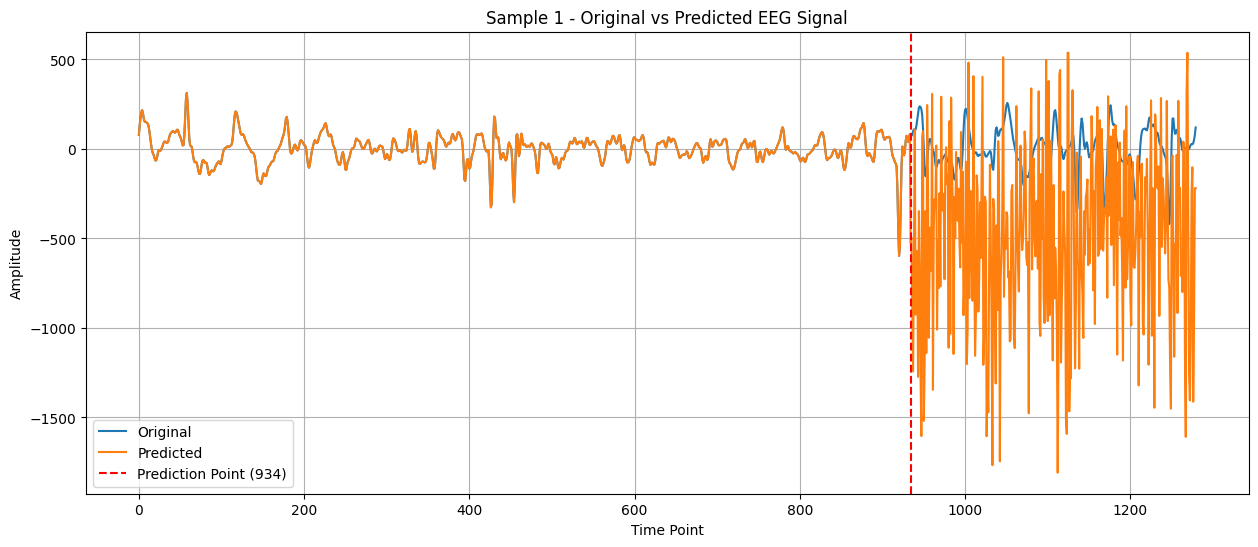

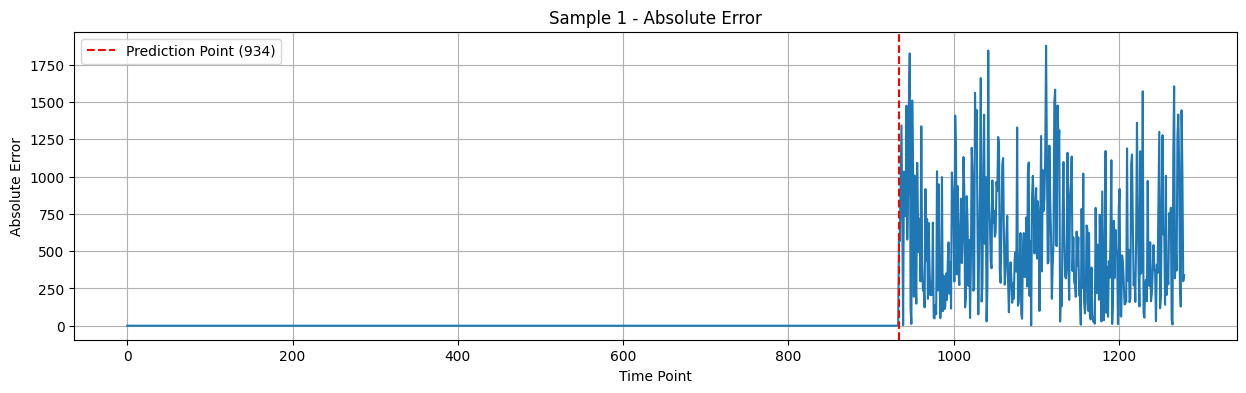

Sample 1 Metrics - MSE: 136765.9531, RMSE: 369.8188, MAE: 154.7453, R²: -15.7992
Predicted Part Metrics - MSE: 505955.0000, RMSE: 711.3051, MAE: 572.4683, R²: -36.2245



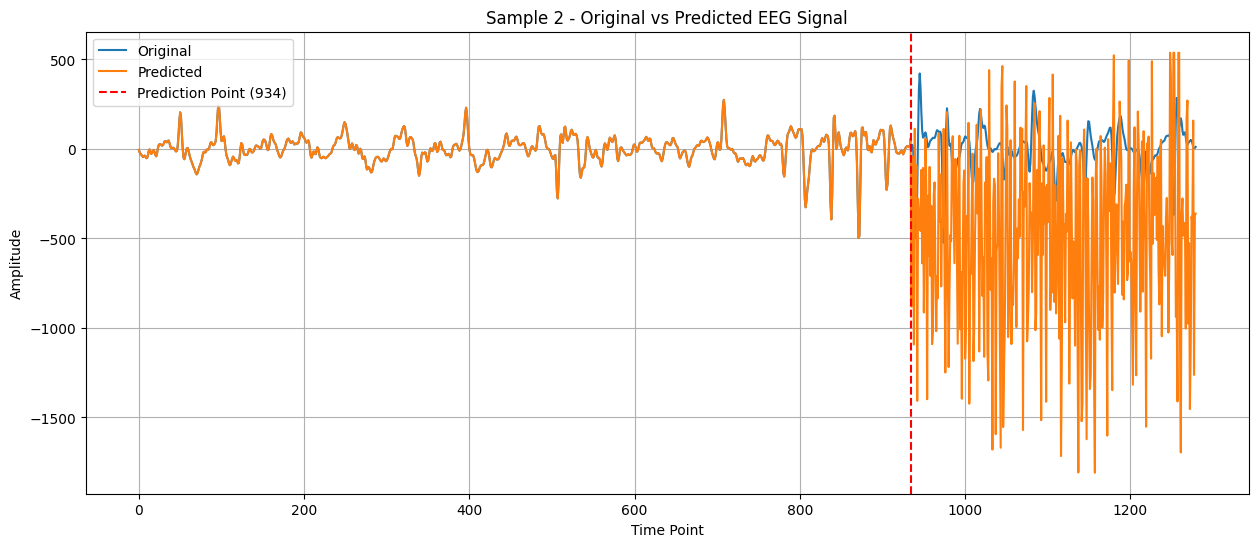

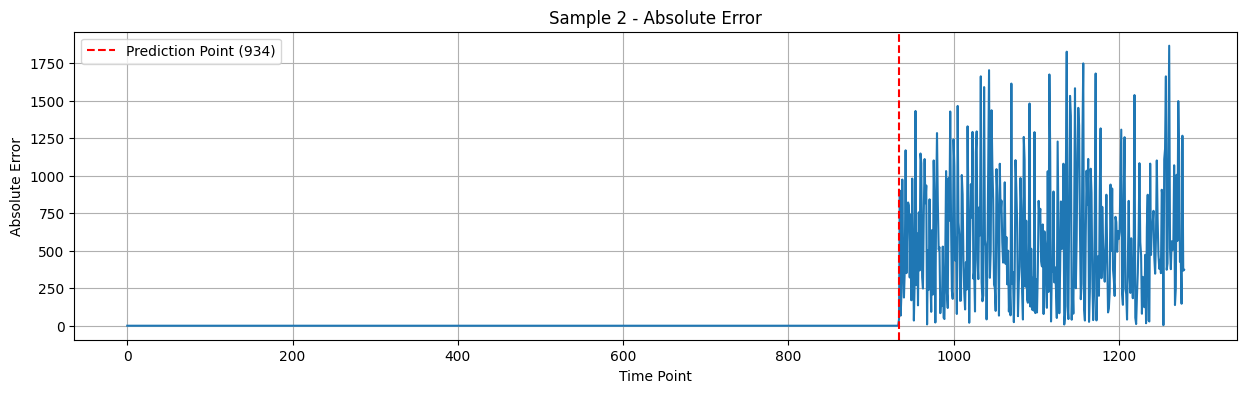

Sample 2 Metrics - MSE: 142938.3281, RMSE: 378.0719, MAE: 157.6020, R²: -16.9800
Predicted Part Metrics - MSE: 528789.2500, RMSE: 727.1790, MAE: 583.0363, R²: -35.4272



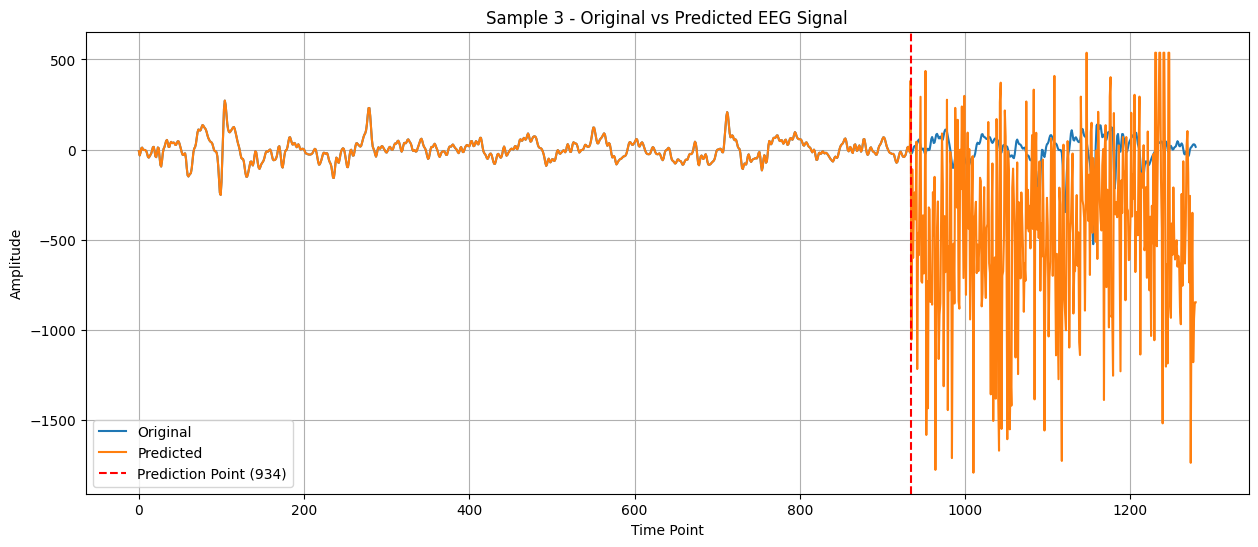

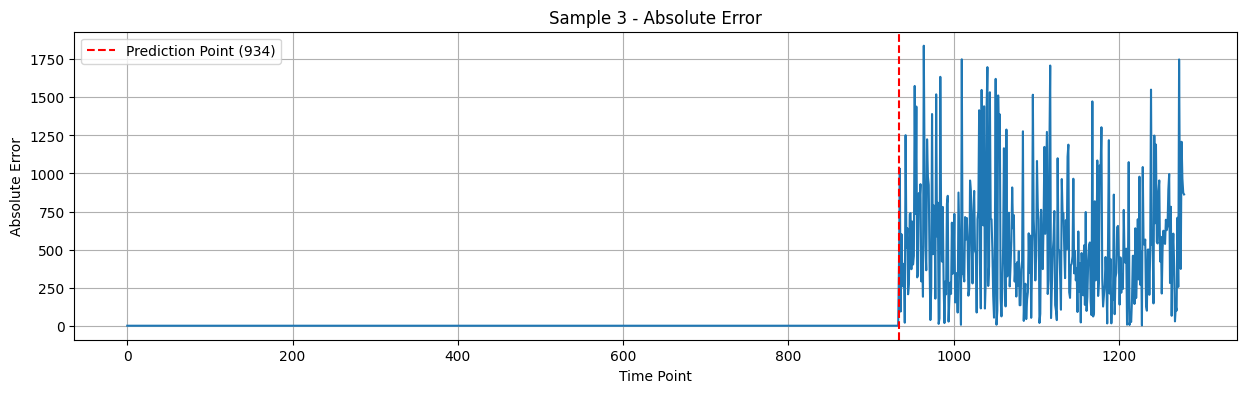

Sample 3 Metrics - MSE: 123291.2734, RMSE: 351.1286, MAE: 146.2917, R²: -26.8324
Predicted Part Metrics - MSE: 456106.4375, RMSE: 675.3565, MAE: 541.1945, R²: -58.4198



In [19]:
# Visualize some test samples
print("\nVisualizing test samples:")
visualize_samples('data/test.csv', num_samples=3, prediction_point=prediction_point)

In [20]:
# Evaluate on test dataset
print("\nEvaluating model on test dataset:")
test_originals, test_predictions, test_metrics = evaluate_dataset(
    'data/test.csv', 
    batch_size=8, 
    prediction_point=prediction_point
)




Evaluating model on test dataset:


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


Overall metrics:
  MSE: 135454.4062
  RMSE: 368.0413
  MAE: 153.0853
  R²: -22.7696

Predicted part metrics:
  MSE: 501102.9688
  RMSE: 707.8863
  MAE: 566.3273
  R²: -57.7952



Plotting average performance:


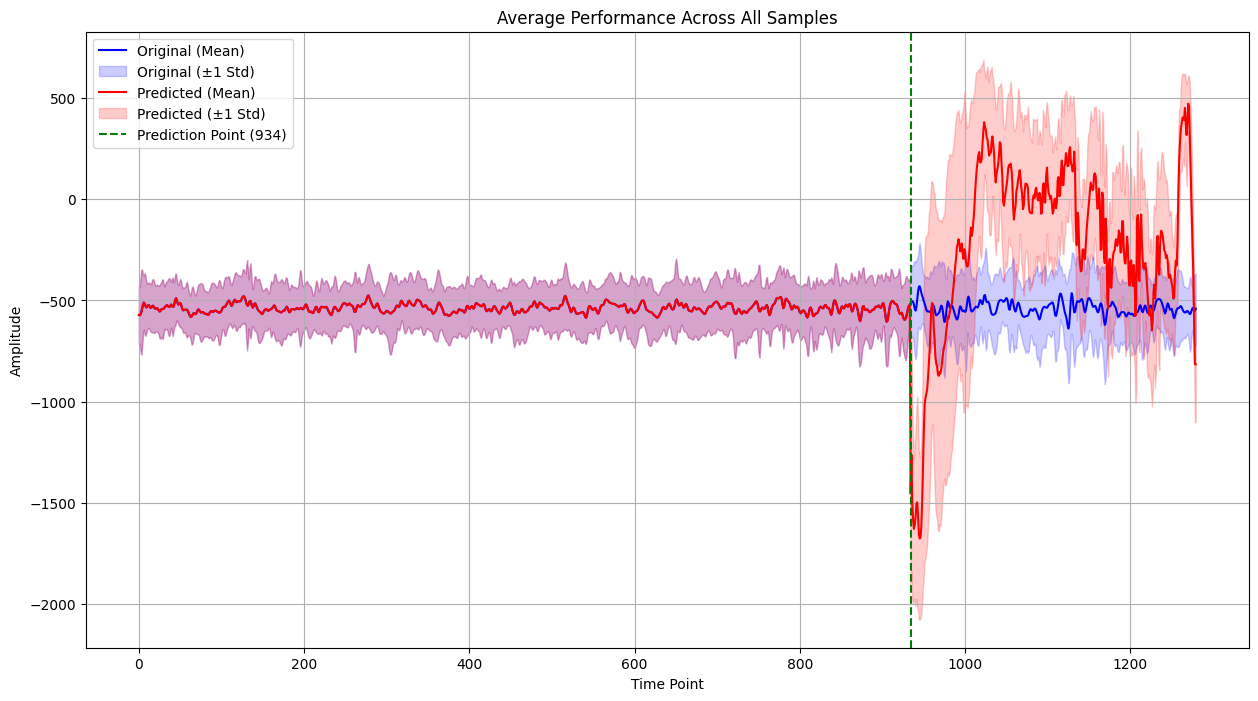

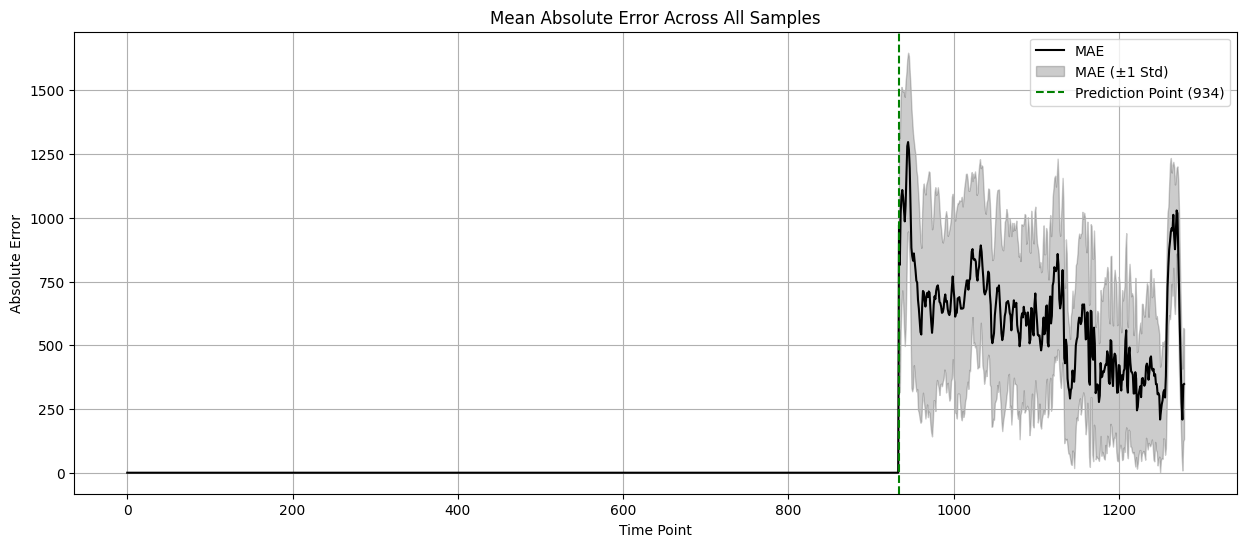

In [9]:
# Plot average performance across all test samples
print("\nPlotting average performance:")
plot_average_performance(test_originals, test_predictions, prediction_point)